In [1]:
import copy
import json
import math
import warnings
from bisect import bisect_left
from collections import Counter

import numpy as np
import pandas as pd
import pandas.io.sql as psql
import psycopg2 as pg
from sqlalchemy import create_engine

warnings.filterwarnings('ignore')

In [99]:
point_type = 'mos_kiosks'
post_points = pd.read_csv(f'{point_type}1.csv').set_index('id')
post_points.head(5)

,global_id,object_type,name,adm_area,district,address,unom,specialization,period_of_placement,facility_area,...,transport_other_in_0.4_km,transport_other_in_0.8_km,work_and_housing_in_0.1_km,work_and_housing_in_0.2_km,work_and_housing_in_0.4_km,work_and_housing_in_0.8_km,religion_in_0.1_km,religion_in_0.2_km,religion_in_0.4_km,religion_in_0.8_km
id,,,,,,,,,,,,,,,,,,,,,
1,861530114,киоск,"НТО ул. Авиационная, вл.68",Северо-Западный административный округ,район Щукино,"город Москва, Авиационная улица, дом 68",127.0,печать,с 1 января по 31 декабря,9,...,3,12,0,0,0,0,0,0,0,0
2,861538110,киоск,"НТО Абрамцевская ул., вл.1",Северо-Восточный административный округ,район Лианозово,"Российская Федерация, город Москва, внутригоро...",27.0,печать,с 1 января по 31 декабря,9,...,0,0,0,0,0,0,0,0,0,0
3,861538112,киоск,"НТО ул. Абрамцевская, вл. 9, к. 1",Северо-Восточный административный округ,район Лианозово,"Российская Федерация, город Москва, внутригоро...",38.0,печать,с 1 января по 31 декабря,9,...,0,0,0,0,1,1,0,0,0,0
4,861538113,киоск,"НТО Абрамцевская ул., вл.14",Северо-Восточный административный округ,район Лианозово,"Российская Федерация, город Москва, внутригоро...",43.0,печать,с 1 января по 31 декабря,6,...,0,0,0,0,0,1,0,0,0,0
5,861538114,киоск,НТО у входа в сквер им. Калинина с ул. Авиамот...,Юго-Восточный административный округ,район Лефортово,"город Москва, Авиамоторная улица, дом 14",95.0,печать,с 1 января по 31 декабря,9,...,12,19,0,0,4,7,0,0,0,0


In [100]:
for idx in range(21, len(post_points.columns), 4):
    for j in (3, 2, 1):
        post_points.iloc[:, idx + j] -= post_points.iloc[:, idx + j - 1]
post_points.head(5)

,global_id,object_type,name,adm_area,district,address,unom,specialization,period_of_placement,facility_area,...,transport_other_in_0.4_km,transport_other_in_0.8_km,work_and_housing_in_0.1_km,work_and_housing_in_0.2_km,work_and_housing_in_0.4_km,work_and_housing_in_0.8_km,religion_in_0.1_km,religion_in_0.2_km,religion_in_0.4_km,religion_in_0.8_km
id,,,,,,,,,,,,,,,,,,,,,
1,861530114,киоск,"НТО ул. Авиационная, вл.68",Северо-Западный административный округ,район Щукино,"город Москва, Авиационная улица, дом 68",127.0,печать,с 1 января по 31 декабря,9,...,1,9,0,0,0,0,0,0,0,0
2,861538110,киоск,"НТО Абрамцевская ул., вл.1",Северо-Восточный административный округ,район Лианозово,"Российская Федерация, город Москва, внутригоро...",27.0,печать,с 1 января по 31 декабря,9,...,0,0,0,0,0,0,0,0,0,0
3,861538112,киоск,"НТО ул. Абрамцевская, вл. 9, к. 1",Северо-Восточный административный округ,район Лианозово,"Российская Федерация, город Москва, внутригоро...",38.0,печать,с 1 января по 31 декабря,9,...,0,0,0,0,1,0,0,0,0,0
4,861538113,киоск,"НТО Абрамцевская ул., вл.14",Северо-Восточный административный округ,район Лианозово,"Российская Федерация, город Москва, внутригоро...",43.0,печать,с 1 января по 31 декабря,6,...,0,0,0,0,0,1,0,0,0,0
5,861538114,киоск,НТО у входа в сквер им. Калинина с ул. Авиамот...,Юго-Восточный административный округ,район Лефортово,"город Москва, Авиамоторная улица, дом 14",95.0,печать,с 1 января по 31 декабря,9,...,1,7,0,0,4,3,0,0,0,0


In [ ]:
feature_columns = post_points.iloc[:,21:].columns

In [15]:
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns

def plot_importance(imps, X, max_num=None, fig_size=(20, 10)):
    if max_num is None:
        max_num = len(X.columns)
    feature_imp = pd.DataFrame({'Value': imps, 'Feature': X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:max_num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [163]:
imps1000 = np.zeros(48)
for _ in range(1000):
    X = post_points.iloc[:,21:]
    y = [5 * np.random.rand(1) + 1 for _ in range(len(X))]

    model = LGBMRegressor()
    model.fit(X, y)
    imps1000 += model.feature_importances_

In [168]:
imps = imps1000  # imps100

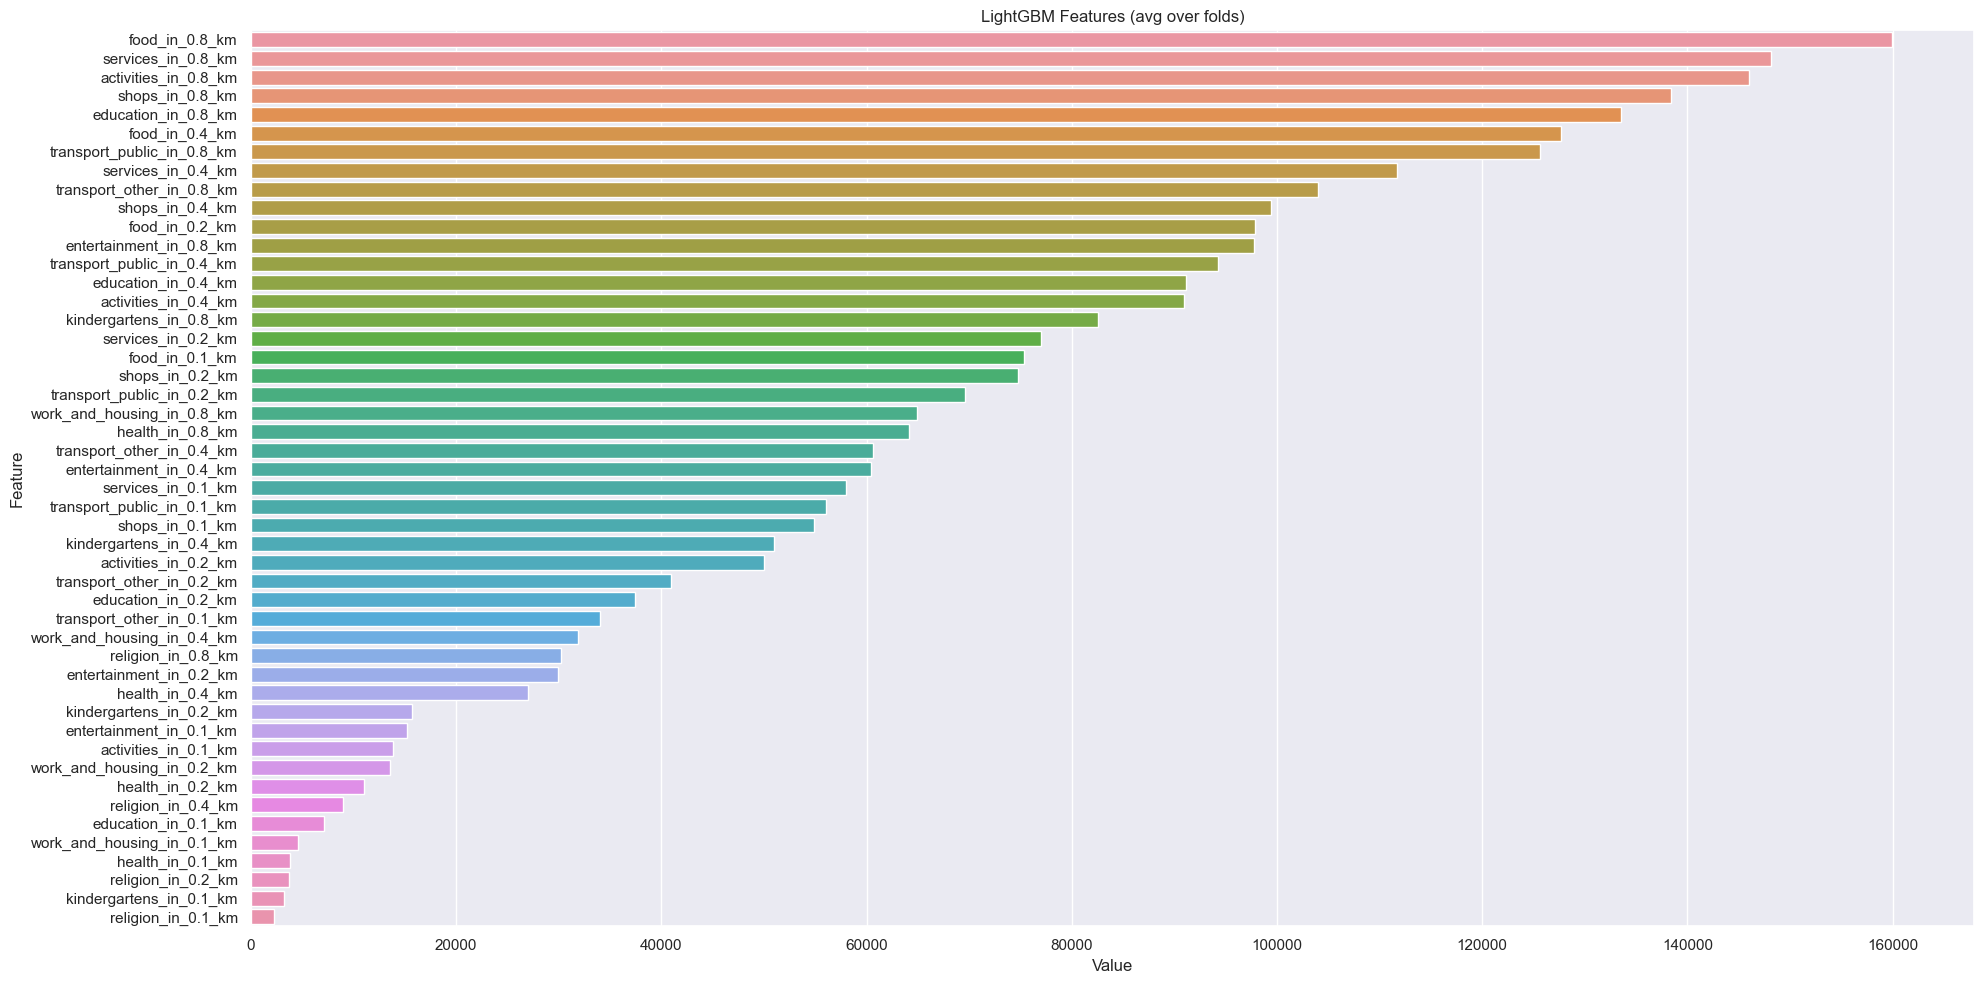

In [169]:
plot_importance(imps, X)

In [170]:
r_weights = [3.1416 * r ** 2 for r in (0.1, 0.2, 0.4, 0.8)]
for j in (3, 2, 1):
    r_weights[j] -= sum(r_weights[:j])
r_weights = {
    str(r): 1 / r_weights[i]
    for i, r in enumerate((0.1, 0.2, 0.4, 0.8))
}
weights = {
    col: w * r_weights[col.split('_km')[0][-3:]] / 1e6
    for col, w in zip(feature_columns, imps)
}
weights

{'activities_in_0.1_km': 0.4398077412783294,
 'activities_in_0.2_km': 0.5307168321874203,
 'activities_in_0.4_km': 0.26326481005625385,
 'activities_in_0.8_km': 0.10807483670000767,
 'entertainment_in_0.1_km': 0.4839572192513368,
 'entertainment_in_0.2_km': 0.3175239792886851,
 'entertainment_in_0.4_km': 0.1748298492950899,
 'entertainment_in_0.8_km': 0.0723894208846329,
 'shops_in_0.1_km': 1.7456391647568115,
 'shops_in_0.2_km': 0.793067226890756,
 'shops_in_0.4_km': 0.28780355117253503,
 'shops_in_0.8_km': 0.10244964793528402,
 'services_in_0.1_km': 1.8452699261522787,
 'services_in_0.2_km': 0.8169191919191916,
 'services_in_0.4_km': 0.3232631895733499,
 'services_in_0.8_km': 0.10969969383102075,
 'health_in_0.1_km': 0.12146676852559202,
 'health_in_0.2_km': 0.11734997029114673,
 'health_in_0.4_km': 0.0781159571266523,
 'health_in_0.8_km': 0.04750060700813094,
 'kindergartens_in_0.1_km': 0.10233638910109497,
 'kindergartens_in_0.2_km': 0.16636957813428396,
 'kindergartens_in_0.4_km':

In [171]:
target = np.sum([post_points[col] * w for col, w in weights.items()], axis=0)
post_points['target'] = target

<AxesSubplot: >

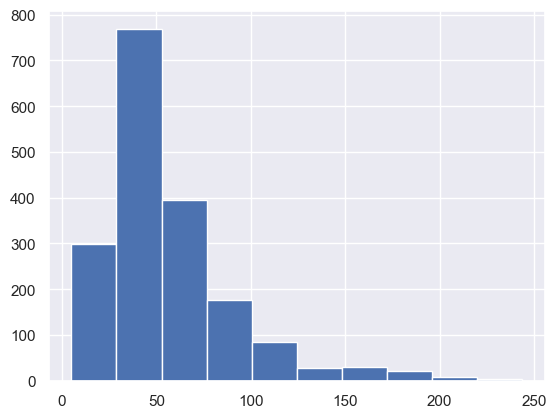

In [172]:
post_points['target'].hist()

In [78]:
engine = create_engine('postgresql://user@localhost:5432/mydb')
connection = pg.connect("host=188.72.109.162 dbname=optimus_post_db user=reader password=aboba")
apo = psql.read_sql('SELECT * FROM automatic_post_offices', connection)
apo

,id,geo_data,area_id,is_placed,address,placement_object_type_id,people_in_range,distance_to_metro,distance_to_bus,predict_a,predict_b,predict_c,created_at,updated_at
0,1,"[37.3984494058106, 55.8442713650879]",121,True,"9331 Ronald Garden, Darellbury, TX 63576",2,45366,734,651,83421.005,29981.015,99374.378,2022-11-04 22:27:14.143034,2022-11-04 22:27:14.143034
1,2,"[37.6425982790263, 55.730883256287]",30,True,"53550 Ivan Port, East Micah, OR 82829-4331",6,20712,670,307,78157.364,13660.411,76807.898,2022-11-04 22:27:14.148074,2022-11-04 22:27:14.148074
2,3,"[37.6982348080737, 55.7205786231207]",122,False,"Apt. 986 831 Carroll Mountains, New Ervin, TN ...",1,31641,909,541,44820.906,19528.631,90217.584,2022-11-04 22:27:14.150988,2022-11-04 22:27:14.150988
3,4,"[37.926862, 55.681275]",66,True,"Apt. 201 2006 Kennith Course, Port Marietown, ...",6,58704,238,461,10275.898,11387.258,83632.861,2022-11-04 22:27:14.153867,2022-11-04 22:27:14.153867
4,5,"[37.7611709566537, 55.6327758568284]",14,True,"Suite 806 62313 Jast Forest, East Weldonview, ...",1,92452,585,638,52797.104,60088.555,27863.296,2022-11-04 22:27:14.156442,2022-11-04 22:27:14.156442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,911,"[37.604874, 55.7314367502887]",123,False,"477 Genevie Streets, Carterside, IA 74322",5,35759,548,851,92301.011,61262.808,26774.897,2022-11-04 22:27:16.488844,2022-11-04 22:27:16.488844
911,912,"[37.481235, 55.860822]",47,False,"Apt. 586 655 Dale Keys, Langoshburgh, TX 55811...",4,49580,276,101,17689.029,26123.956,63512.421,2022-11-04 22:27:16.491358,2022-11-04 22:27:16.491358
912,913,"[37.497202, 55.8234127770431]",18,True,"167 Goyette Common, Kelseytown, ND 40703-3932",6,86779,563,135,26945.277,42361.359,99786.457,2022-11-04 22:27:16.493821,2022-11-04 22:27:16.493821
913,914,"[37.6519829908832, 55.6481804899571]",62,True,"Suite 139 13389 Andreas Ways, Bayerland, TX 96707",2,96423,527,183,69833.701,81323.671,52539.887,2022-11-04 22:27:16.496276,2022-11-04 22:27:16.496276


In [176]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import ast

engine = create_engine('postgresql://user@localhost:5432/mydb')
connection = pg.connect("host=188.72.109.162 dbname=optimus_post_db user=reader password=aboba")
areasDf = psql.read_sql('SELECT * FROM areas', connection)
areasDf['polygon'] = areasDf['polygon'].apply(ast.literal_eval)
areasDf

def get_area_id(coords):
    point = Point(coords)
    for index, row in areasDf.iterrows():
        if row['polygon_type'] == 0:
            tmpPolygon = Polygon(row['polygon'][0])
            if tmpPolygon.contains(point) == True:
                return row['id']
        else:
            for pol in row['polygon']:
                tmpPolygon = Polygon(pol)
                if tmpPolygon.contains(point) == True:
                    return row['id']
    return -1

In [177]:
kiosk_obj_type_id = 3

post_targets = post_points.reset_index()[['id']].set_index('id')
post_targets['geo_data'] = list(map(lambda x: list(map(float, x[1:-1].split(', '))), post_points['coordinates']))
post_targets['area_id'] = list(map(get_area_id, post_targets['geo_data']))
post_targets['is_placed'] = ['false'] * len(post_targets)
post_targets['address'] = post_points['address']
post_targets['placement_object_type_id'] = [kiosk_obj_type_id] * len(post_targets)
post_targets['people_in_range'] = [0] * len(post_targets)
post_targets['distance_to_metro'] = [0] * len(post_targets)
post_targets['distance_to_bus'] = [0] * len(post_targets)
post_targets['predict_a'] = post_points['target']
post_targets['predict_b'] = [0] * len(post_targets)
post_targets['predict_c'] = [0] * len(post_targets)
post_targets

,geo_data,area_id,is_placed,address,placement_object_type_id,people_in_range,distance_to_metro,distance_to_bus,predict_a,predict_b,predict_c
id,,,,,,,,,,,
1,"[37.4562557224584, 55.8097215134657]",118,false,"город Москва, Авиационная улица, дом 68",3,0,0,0,27.336751,0,0
2,"[37.5734227039377, 55.8934729310499]",49,false,"Российская Федерация, город Москва, внутригоро...",3,0,0,0,36.478966,0,0
3,"[37.5737538639508, 55.9045160525638]",49,false,"Российская Федерация, город Москва, внутригоро...",3,0,0,0,29.246858,0,0
4,"[37.5741204640462, 55.9013866894025]",49,false,"Российская Федерация, город Москва, внутригоро...",3,0,0,0,36.104779,0,0
5,"[37.716752, 55.752735]",48,false,"город Москва, Авиамоторная улица, дом 14",3,0,0,0,105.491059,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1809,"[37.5126350943992, 55.6072364619889]",125,false,"город Москва, Голубинская улица, дом 5, корпус 1",3,0,0,0,18.131221,0,0
1810,"[37.4984607003198, 55.6670500366785]",106,false,"Российская Федерация, город Москва, внутригоро...",3,0,0,0,14.000563,0,0
1811,"[37.4373710271288, 55.8264181141557]",79,false,"город Москва, проезд Стратонавтов, дом 9, корп...",3,0,0,0,67.691072,0,0


In [179]:
post_targets.to_csv('automatic_post_offices_best.csv', index=False)